# Splitting the data into time-periods

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import json
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

master = pd.read_csv('final_data_set.csv', sep = ';', encoding = 'utf-8')

master = master.query('laureate_name!="vanvleck, jh"').copy() # Han er der 2 gange 

In [2]:
master = master.dropna(subset=["laureate_name", "affiliation", 'uni_nationality']) # remove missing

''' Split into timeperiods - take the carreers of the nobel laurates of the 4 periods '''
first_period = master.query('prize_year <= 1939').copy()
second_period = master.query('prize_year >= 1940 and prize_year <= 1969').copy()
third_period = master.query('prize_year >= 1970 and prize_year <= 1999').copy()
fourth_period = master.query('prize_year >= 2000').copy()

''' How many years? '''
print('How many year')
print(len(first_period.drop_duplicates(["prize_year"])))
print(len(second_period.drop_duplicates(["prize_year"])))
print(len(third_period.drop_duplicates(["prize_year"])))
print(len(fourth_period.drop_duplicates(["prize_year"])))

''' How many people? '''
print('How many laureates')
print(len(first_period.drop_duplicates(["prize_year", 'laureate_name'])))
print(len(second_period.drop_duplicates(["prize_year", 'laureate_name'])))
print(len(third_period.drop_duplicates(["prize_year", 'laureate_name'])))
print(len(fourth_period.drop_duplicates(["prize_year", 'laureate_name'])))

How many year
22
27
30
17
How many laureates
44
108
181
118


In [3]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(G=None, top_n = 50, hue_name = None ,hue_dict = None, title = ''):
    
    _df = pd.DataFrame(sorted(dict(G.degree()).items(), key = lambda x: x[1], reverse = True)[:top_n],
                       columns = ['Name','count'])

    _df[hue_name] = _df.Name.apply(lambda x: hue_dict[x])
    
    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(data = _df, x='Name', y='count', hue = hue_name, palette = "deep",ax=ax)
    ax.set_ylabel('Degree', size = 15)
    ax.set_xlabel(None)
    plt.xticks(rotation=90, size = 12)
    ax.set_title(f'Degree distribution for top {top_n} node - {title}', size = 15)
    return fig


''' Recolor nodes based on a partition dictionary and colormap 
    Only works if all nodes in nx_configs are in partition_dict as well '''

def redefine_attr(nx_configs, partition_dict, _sort = False , _cmap = plt.cm.Spectral_r):
    import copy
    import matplotlib
    import random
    ''' Using The sort parameter, you can reference at dict to sort the attributes by,
    where the dicts keys is the attribute, and the dicts value represents some order '''
    
    if _sort:
        _keys = sorted(set(partition_dict.values()), key = lambda x: _sort[x], reverse = True)
    else:
        _keys = list(set(partition_dict.values())) # the attribute classes
        random.shuffle(_keys) # shuffle order - 
        
    n_keys = len(_keys) # how many are there? how many colors do we need?
    # assign each attribute class a unique value between 0 and 1
    # _num/(n_keys-1) --> standarize score with 0 and 1 as min and max
    attr_scale_dict = {_cat:_num/(n_keys-1) for _cat, _num in zip(_keys, range(n_keys))}

    # Copy dict - deep copy as the values are nested in a list
    new_nw = copy.deepcopy(nx_configs)
    
    for node_nr in range(len(nx_configs['nodes'])):
        node = nx_configs['nodes'][node_nr]['id'] # node id 
        attr = partition_dict[node] # get the attribute class of the node
        num_attr = attr_scale_dict[attr] # get the numerical 
        _cmap_color = _cmap(num_attr)
        # overwrite node color based on new attr
        new_nw['nodes'][node_nr]['color'] = matplotlib.colors.rgb2hex(_cmap_color) 
        
    return new_nw

# -1939

In [41]:
import networkx as nx
from networkx.algorithms import bipartite
import netwulf as nw
plt.style.use('ggplot')

''' Create network '''
G_bi = nx.Graph()
G_bi.add_nodes_from(first_period["laureate_name"], bipartite = 0)
G_bi.add_nodes_from(first_period["affiliation"], bipartite = 1)
edge_list = list(first_period[["laureate_name", "affiliation"]].to_records(index=False))
G_bi.add_edges_from(edge_list)

node_attr = {n:d["bipartite"] for n, d in G_bi.nodes(data=True)}
nx.set_node_attributes(G_bi, node_attr, name = 'group')

''' make weights '''
edge_w_dict = {tuple(key):0 for key in edge_list}
for key in edge_list:
    edge_w_dict[tuple(key)] += 1
    
# We Set weights 
nx.set_edge_attributes(G_bi, edge_w_dict, name = "weight")

In [44]:
with open('nx_configs/bipartite_1939.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bi, plot_in_cell_below=False, config = config)

In [43]:
''' Run if config needs chaning '''
# network, config = nw.visualize(G_bi, plot_in_cell_below=False) # Run netwulf

In [7]:
# with open('nx_configs/bipartite_1939.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

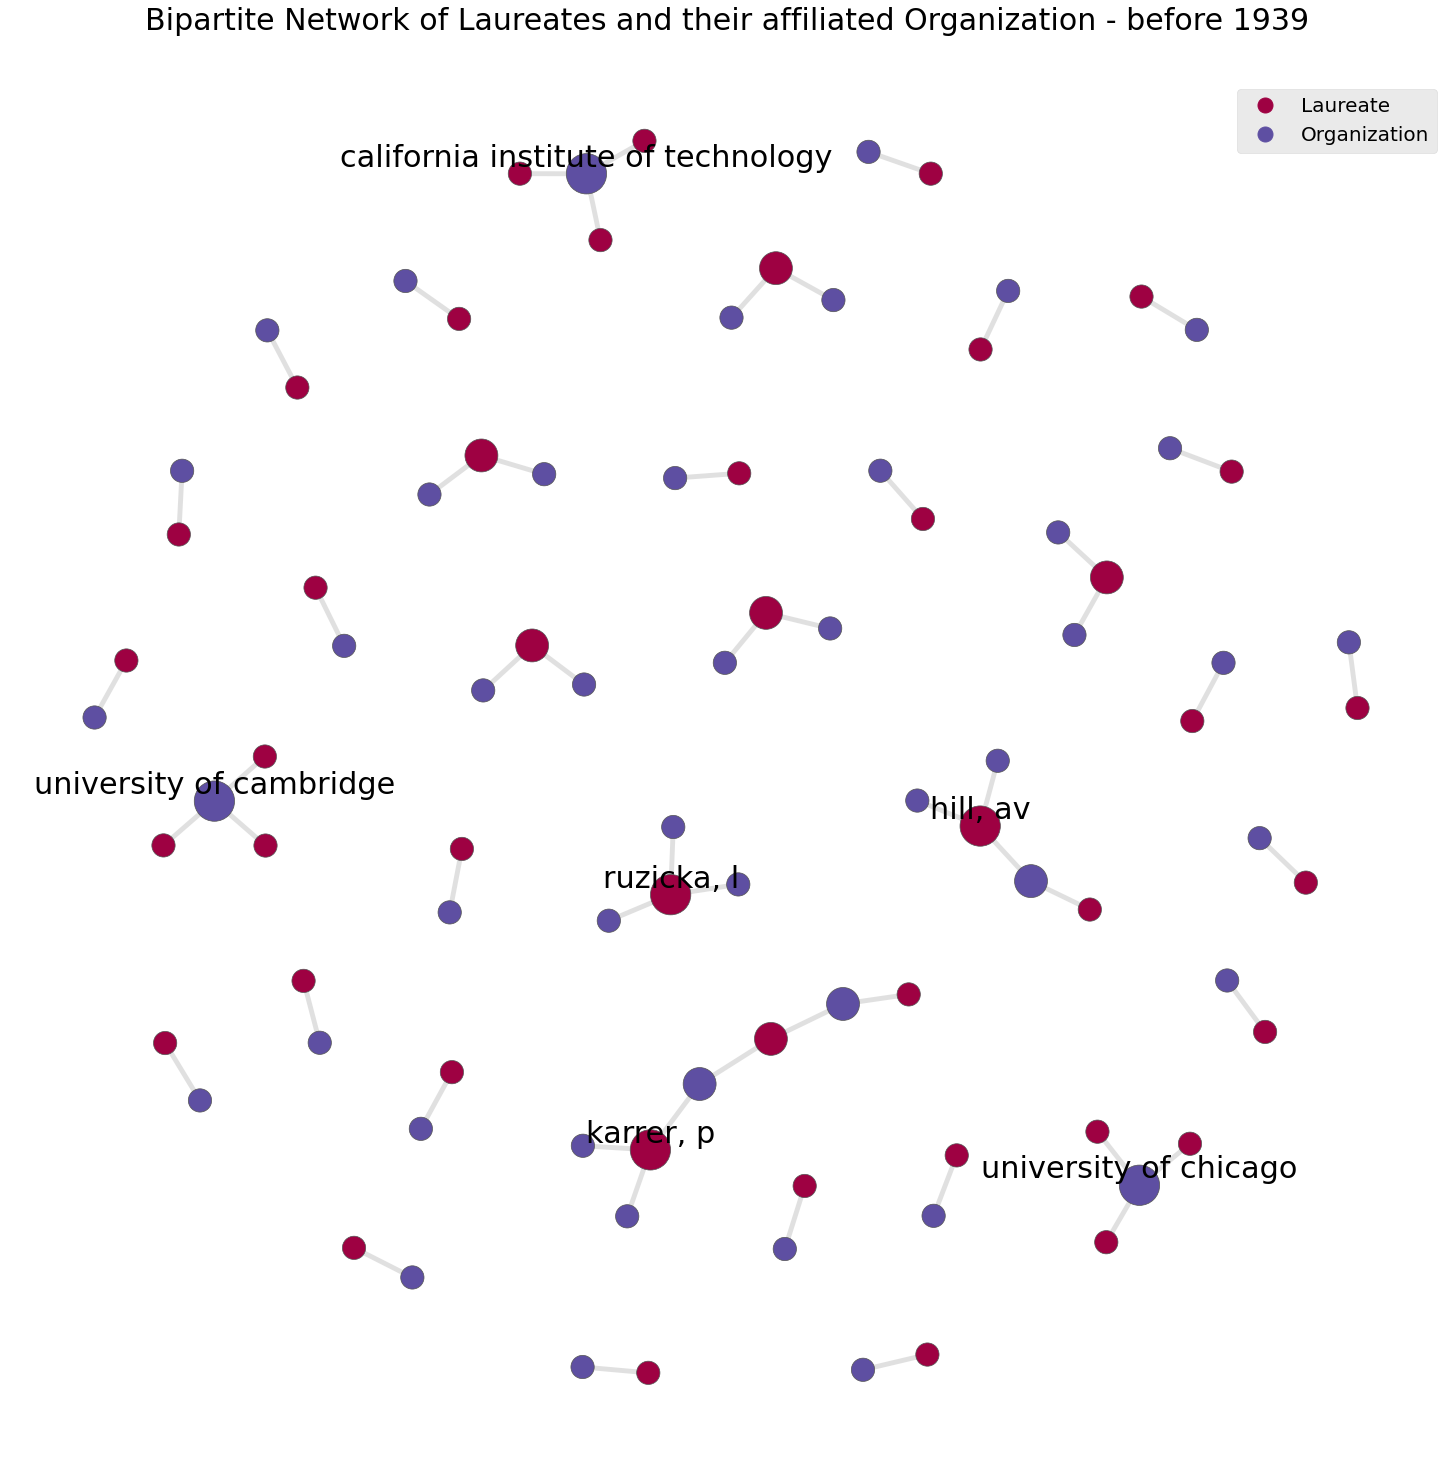

In [8]:
with open('nx_configs/bipartite_1939.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bi, plot_in_cell_below=False, config = config)

network = redefine_attr(network, node_attr) # colormap it

# Drawing a big figure
plt.rcParams["figure.figsize"] = (20,20)

# Drawing the network
fig, ax = nw.draw_netwulf(network)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>13: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*2)
    else:
        pass



''' attribute/hue dicts '''
laureate_dict = dict.fromkeys(first_period["laureate_name"], "Laureate")
university_dict = dict.fromkeys(first_period["affiliation"], "Organization")
laureate_dict.update(university_dict)


val_map = {laureate_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 15)

# Place legend
plt.legend(bbox_to_anchor = (1,0.97), fontsize = 20)
ax.set_title(f'Bipartite Network of Laureates and their affiliated Organization - before 1939', size = 30)

# Saving as pdf
plt.savefig(f'Plots/before 1939/bipartite_laureate_uni.', dpi=300, facecolor='w', edgecolor='w',
            bbox_inches="tight")

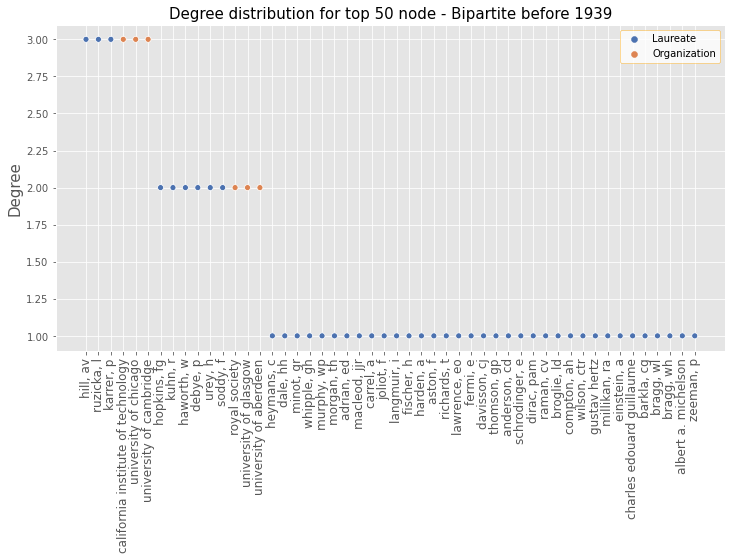

In [11]:
''' top nodes in bipartite network'''
f = plot_top_nodes(G=G_bi,
           hue_name = '',
           hue_dict = laureate_dict,
           title = f'Bipartite before 1939')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

f.savefig(f'Plots/before 1939/top_connected.', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [54]:
G_top_pro = bipartite.projection.weighted_projected_graph(G_bi, bottom_nodes)
G_top_pro.edges(data=True)

EdgeDataView([('ciba specialty chemicals', 'ecole polytechnique', {'weight': 1}), ('ciba specialty chemicals', 'technische hochschule', {'weight': 1}), ('cornell university', 'leipzig university', {'weight': 1}), ('hoffmann la roche', 'university of zurich', {'weight': 1}), ('hoffmann la roche', 'university of glasgow', {'weight': 1}), ('technische hochschule', 'ecole polytechnique', {'weight': 1}), ('royal society', 'university college london', {'weight': 1}), ('royal society', 'marine biological laboratory', {'weight': 1}), ('university of glasgow', 'university of aberdeen', {'weight': 1}), ('university of glasgow', 'university of zurich', {'weight': 1}), ('marine biological laboratory', 'university college london', {'weight': 1}), ('national institute of standards and technology', 'university of california san diego', {'weight': 1}), ('united states department of agriculture', 'guy s hospital', {'weight': 1}), ('university of pennsylvania', 'max planck society', {'weight': 1}), ('un

In [45]:
#### Split into projections ####
top_nodes = {n for n, d in G_bi.nodes(data=True) if d["bipartite"] == 0} # Laureates 
bottom_nodes = set(G_bi) - top_nodes

## Projections 
G_top_pro = bipartite.projection.projected_graph(G_bi, top_nodes) # laureates 
G_bottom_pro = bipartite.projection.projected_graph(G_bi, bottom_nodes) # affiliation 

''' Nationality hue for laureates '''
first_period.nationality = first_period.nationality.apply(lambda x: x.split(',')[0])
name_nat_dict = {name:nat for name, nat in zip(first_period.laureate_name, first_period.nationality)}

# Assign communty labels
nx.set_node_attributes(G_top_pro, name_nat_dict, 'group')

In [13]:
''' Run if configs needs changing '''
# #Use netwulf to visualize
# network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

' Run if configs needs changing '

In [14]:
''' Save if necesarry '''
# with open('nx_configs/lau_bipartite_1939.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' Save if necesarry '

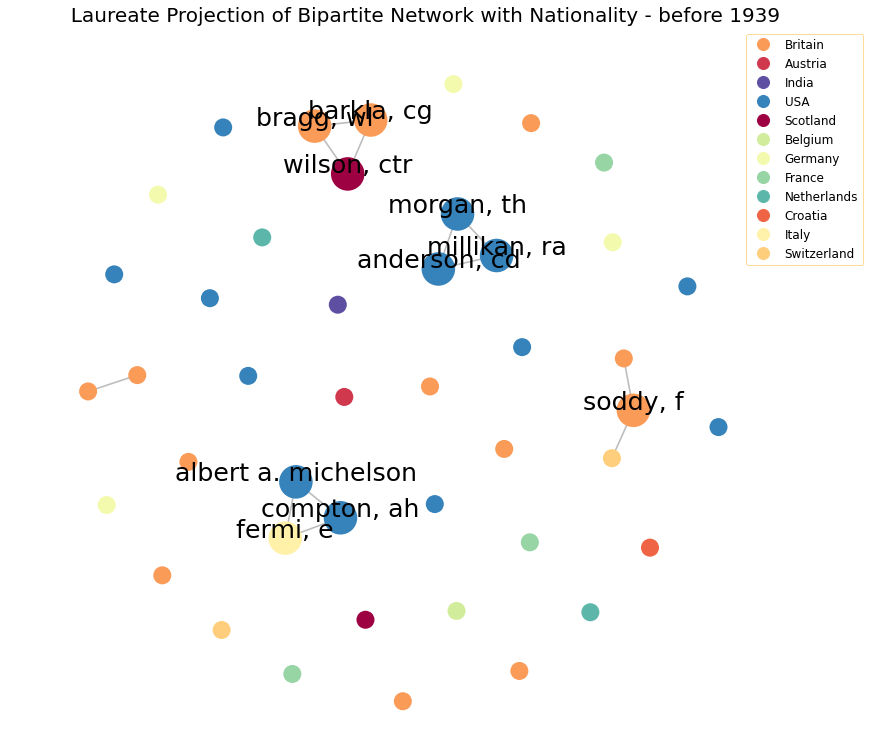

In [21]:
with open('nx_configs/lau_bipartite_1939.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False, config = config)

network = redefine_attr(network, name_nat_dict) # colormap it

plt.rcParams["figure.figsize"] = (30,30)

fig, ax = nw.draw_netwulf(network, figsize = 10)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>25: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass


    
ax.set_title(f'          Laureate Projection of Bipartite Network with Nationality - before 1939', size = 20)

# Drawing a big figure


val_map = {name_nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
# Place legend
legend = plt.legend(bbox_to_anchor = (1.16,1.), fontsize = 12)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')
# Saving as pdf
plt.savefig(f'Plots/before 1939/laureate_projection_nationality.png', dpi=300, bbox_inches='tight')

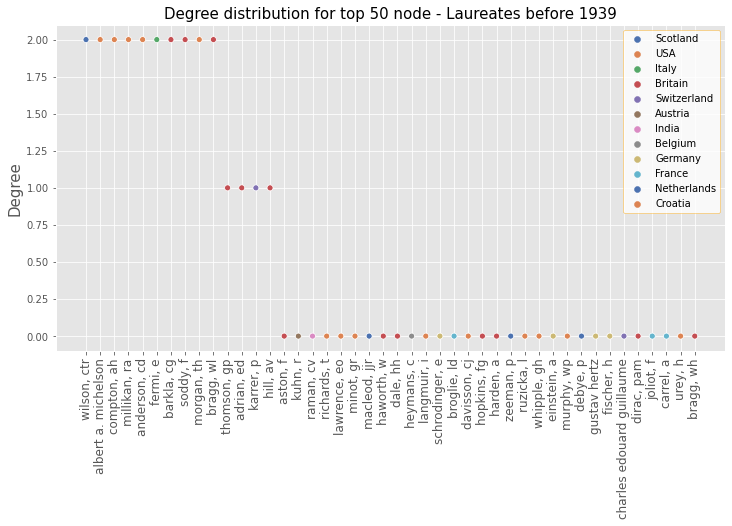

In [22]:
''' Top Laureate nodes with nationality as Hue '''
f = plot_top_nodes(G=G_top_pro,
               hue_name = '',
               hue_dict = name_nat_dict,
               title = f"Laureates before 1939")

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

f.savefig(f'Plots/before 1939/top_connected_laureate_bipart.png', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [23]:
''' Continent hue for organization ''' 
nat_dict = {name:(nat if pd.isna(nat)==False else 'USA') \
            for name, nat in zip(first_period.affiliation, first_period.uni_nationality)}

# Assign communty labels
nx.set_node_attributes(G_bottom_pro, nat_dict, 'group')

In [24]:
''' Run if configs needs changing'''
#Use netwulf to visualize
# network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

' Run if configs needs changing'

In [25]:
# ''' Save if necesarry '''
# with open('nx_configs/org_bipartite_1939.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

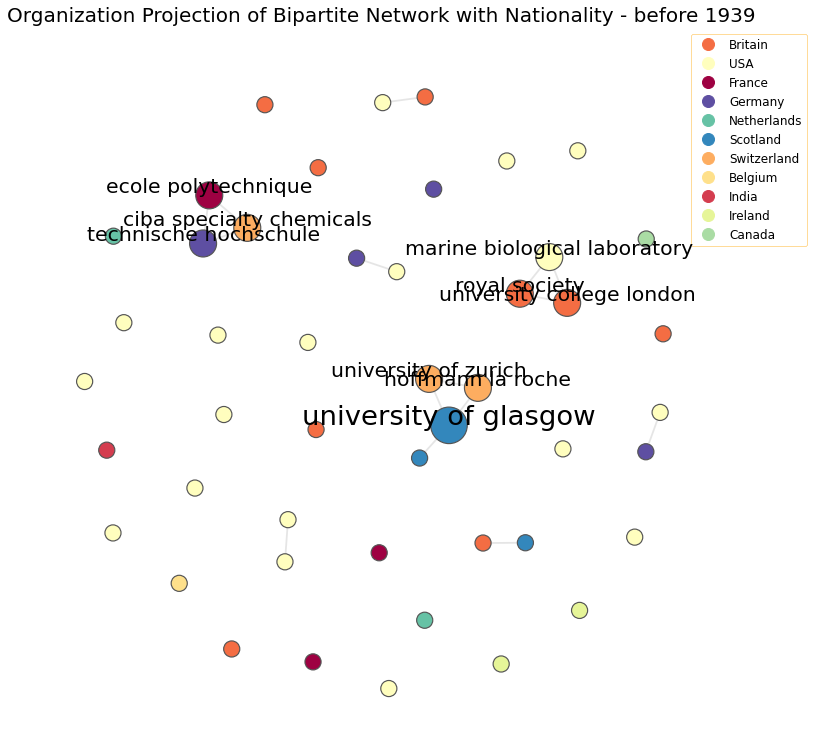

In [26]:
with open('nx_configs/org_bipartite_1939.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False, config = config)

network = redefine_attr(network, nat_dict) # colormap it

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

fig, ax = nw.draw_netwulf(network, figsize = 10)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>20: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass


    
ax.set_title(f'Organization Projection of Bipartite Network with Nationality - before 1939', size = 20)


val_map = {nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)

# Place legend
legend = plt.legend(bbox_to_anchor = (1.1,1), fontsize = 12)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
fig.tight_layout()
plt.savefig(f'Plots/before 1939/university_projection_continent.png', dpi=300, bbox_inches='tight')

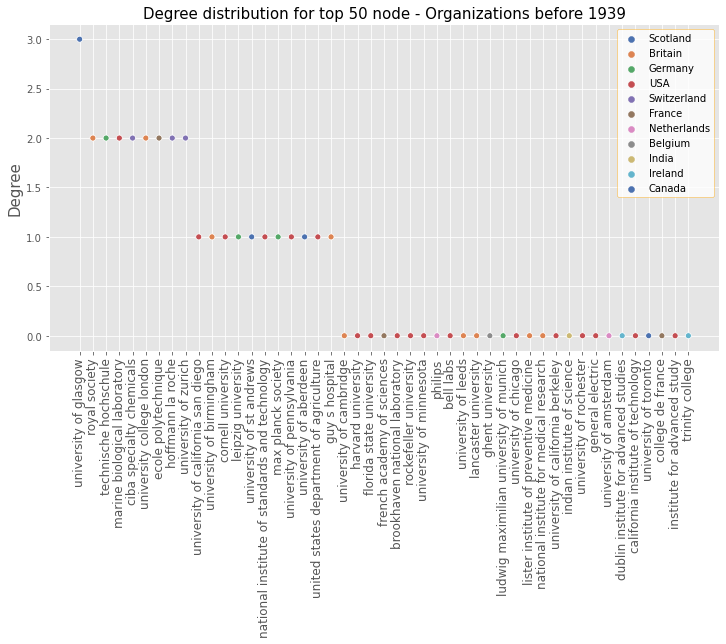

In [27]:
''' Top organization nodes with nationality as Hue '''
f = plot_top_nodes(G=G_bottom_pro,
               hue_name = '',
               hue_dict = nat_dict,
               title = f"Organizations before 1939")

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
f.savefig(f'Plots/before 1939/top_connected_university_bipart.png', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

# 1940-1969

In [28]:
_df = second_period
_period = "1940-1969"
_con_per = "1940_69"

In [29]:
import networkx as nx
from networkx.algorithms import bipartite
import netwulf as nw
plt.style.use('ggplot')

''' Create network '''
G_bi = nx.Graph()
G_bi.add_nodes_from(_df["laureate_name"], bipartite = 0)
G_bi.add_nodes_from(_df["affiliation"], bipartite = 1)
edge_list = list(_df[["laureate_name", "affiliation"]].to_records(index=False))
G_bi.add_edges_from(edge_list)

node_attr = {n:d["bipartite"] for n, d in G_bi.nodes(data=True)}
nx.set_node_attributes(G_bi, node_attr, name = 'group')

In [30]:
''' Run if config needs chaning '''
# network, config = nw.visualize(G_bi, plot_in_cell_below=False) # Run netwulf

' Run if config needs chaning '

In [31]:
''' If new configs should be saved'''
# with open(f'nx_configs/bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' If new configs should be saved'

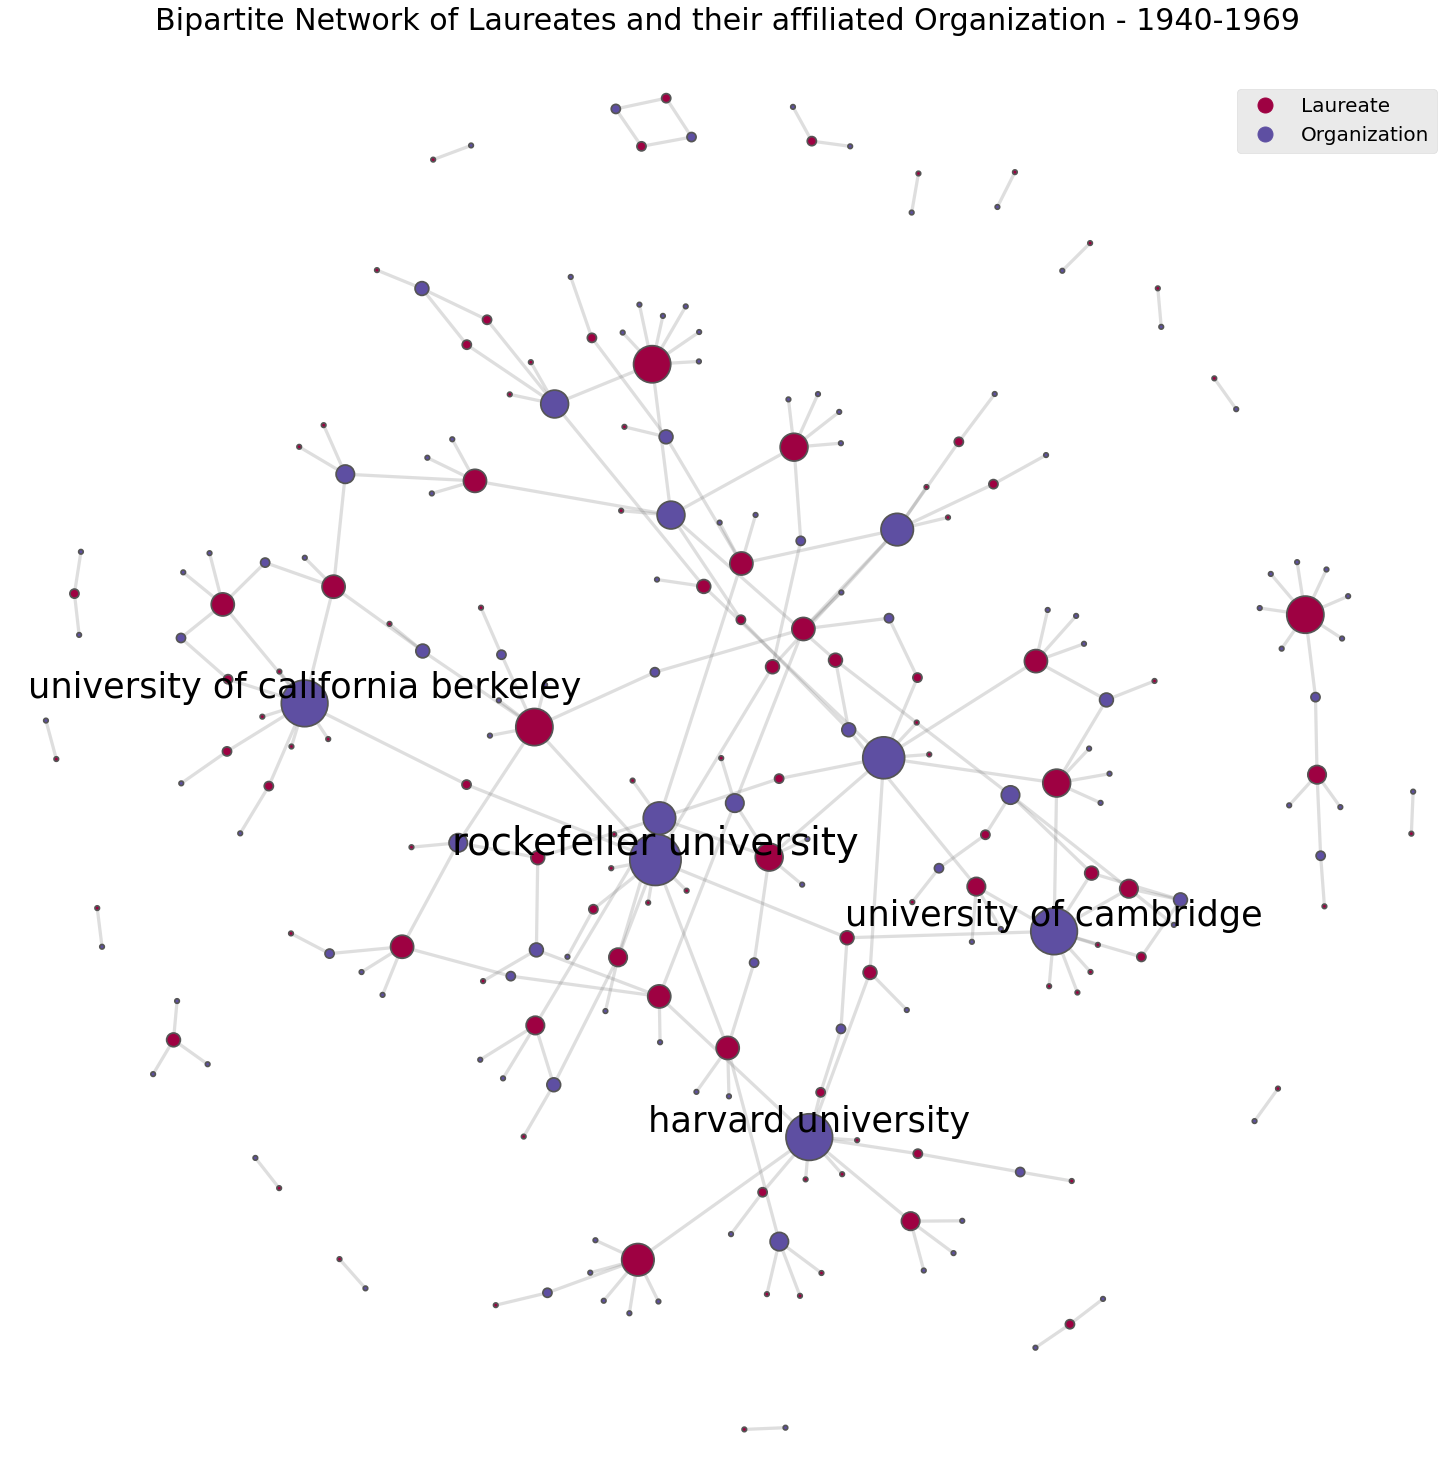

In [32]:
with open(f'nx_configs/bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bi, plot_in_cell_below=False, config = config)

network = redefine_attr(network, node_attr) # colormap it

# Drawing a big figure
plt.rcParams["figure.figsize"] = (20,20)

# Drawing the network
fig, ax = nw.draw_netwulf(network)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>16: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*2)
    else:
        pass



''' attribute/hue dicts '''
laureate_dict = dict.fromkeys(_df["laureate_name"], "Laureate")
university_dict = dict.fromkeys(_df["affiliation"], "Organization")
laureate_dict.update(university_dict)


val_map = {laureate_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 15)

# Place legend
plt.legend(bbox_to_anchor = (1,0.97), fontsize = 20)
ax.set_title(f'Bipartite Network of Laureates and their affiliated Organization - {_period}', size = 30)

# Saving as pdf
plt.savefig(f'Plots/{_period}/bipartite_laureate_uni.', dpi=300, facecolor='w', edgecolor='w',
            bbox_inches="tight")

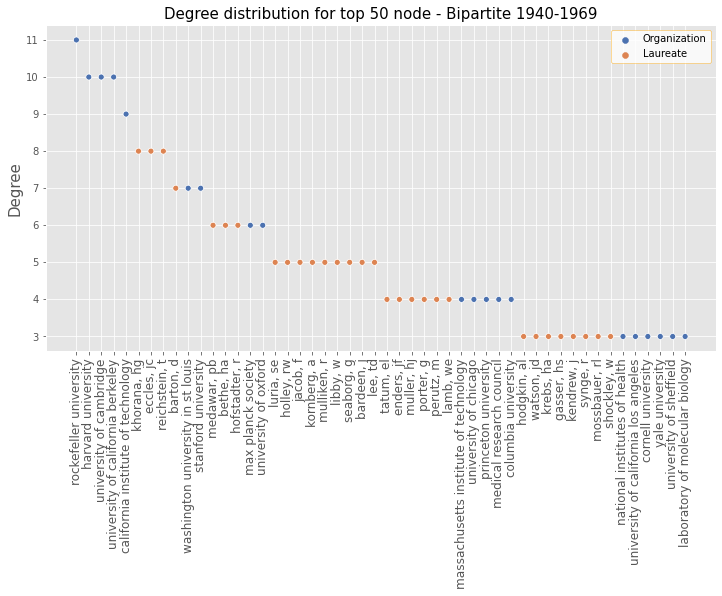

In [33]:
''' top nodes in bipartite network'''
f = plot_top_nodes(G=G_bi,
           hue_name = '',
           hue_dict = laureate_dict,
           title = f'Bipartite {_period}')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

f.savefig(f'Plots/{_period}/top_connected.', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [34]:
#### Split into projections ####
top_nodes = {n for n, d in G_bi.nodes(data=True) if d["bipartite"] == 0} # Laureates 
bottom_nodes = set(G_bi) - top_nodes

## Projections 
G_top_pro = bipartite.projection.projected_graph(G_bi, top_nodes) # laureates 
G_bottom_pro = bipartite.projection.projected_graph(G_bi, bottom_nodes) # affiliation 

''' Nationality hue for laureates '''
_df.nationality = _df.nationality.apply(lambda x: x.split(',')[0])
name_nat_dict = {name:nat for name, nat in zip(_df.laureate_name, _df.nationality)}

# Assign communty labels
nx.set_node_attributes(G_top_pro, name_nat_dict, 'group')

In [35]:
''' Run if configs needs changing '''
# #Use netwulf to visualize
# network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

' Run if configs needs changing '

In [36]:
''' Save if necesarry '''
# with open(f'nx_configs/lau_bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' Save if necesarry '

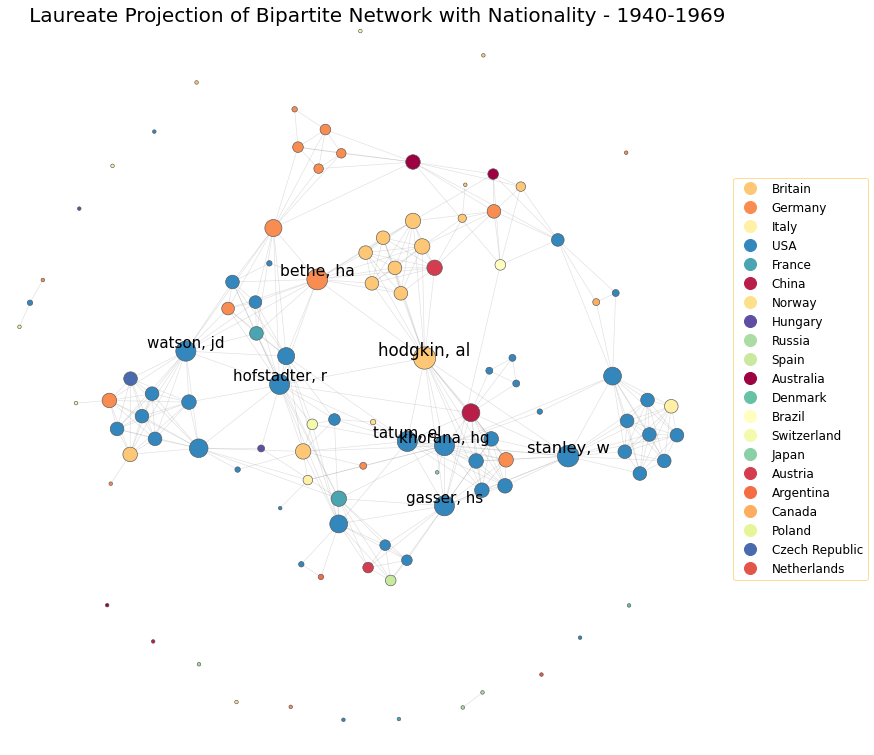

In [37]:
with open(f'nx_configs/lau_bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False, config = config)

network = redefine_attr(network, name_nat_dict) # colormap it

fig, ax = nw.draw_netwulf(network, figsize = 10)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>15: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass


    
ax.set_title(f'   Laureate Projection of Bipartite Network with Nationality - {_period}', size = 20)

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {name_nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
# Place legend
legend = plt.legend(bbox_to_anchor = (1,0.8), fontsize = 12)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')


# Saving as pdf
plt.savefig(f'Plots/{_period}/laureate_projection_nationality.png', dpi=300, bbox_inches='tight')

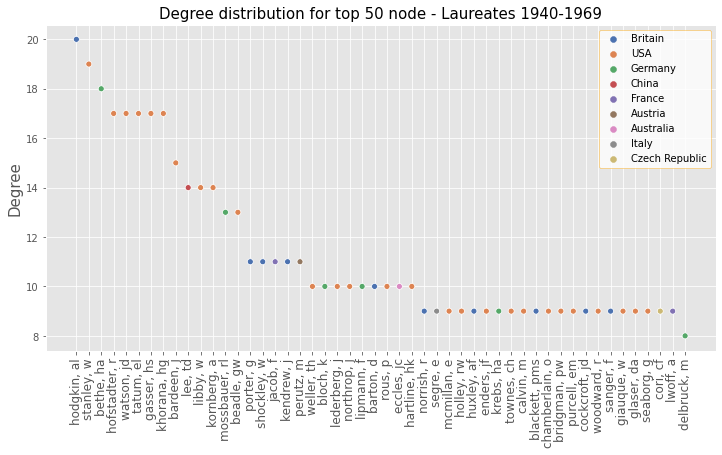

In [39]:
''' Top Laureate nodes with nationality as Hue '''
f = plot_top_nodes(G=G_top_pro,
               hue_name = '',
               hue_dict = name_nat_dict,
               title = f"Laureates {_period}")

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

f.savefig(f'Plots/{_period}/top_connected_laureate_bipart.png', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [40]:
''' Continent hue for organization ''' 
nat_dict = {name:(nat if pd.isna(nat)==False else 'USA') \
            for name, nat in zip(_df.affiliation, _df.uni_nationality)}

# Assign communty labels
nx.set_node_attributes(G_bottom_pro, nat_dict, 'group')

In [41]:
''' Run if configs needs changing'''
#Use netwulf to visualize
# network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

' Run if configs needs changing'

In [42]:
# ''' Save if necesarry '''
# with open(f'nx_configs/org_bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

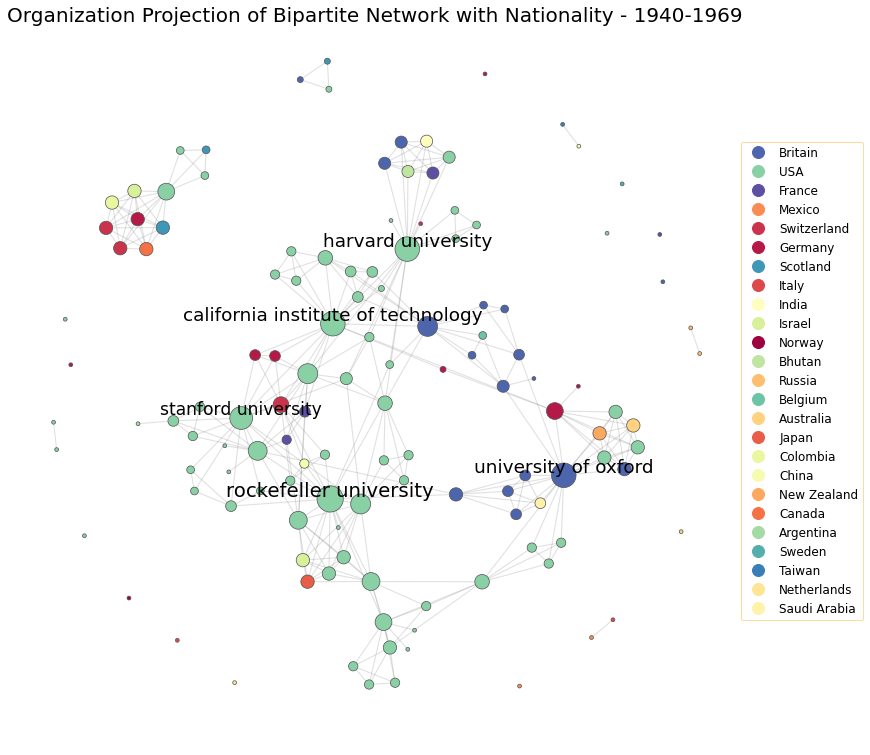

In [45]:
with open(f'nx_configs/org_bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False, config = config)
network = redefine_attr(network, nat_dict) # colormap it

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

fig, ax = nw.draw_netwulf(network, figsize = 10)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>17: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass


    
ax.set_title(f'Organization Projection of Bipartite Network with Nationality - {_period}', size = 20)


val_map = {nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)

# Place legend
legend = plt.legend(bbox_to_anchor = (1,0.85), fontsize = 12)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
fig.tight_layout()
plt.savefig(f'Plots/{_period}/university_projection_continent.png', dpi=300, bbox_inches='tight')

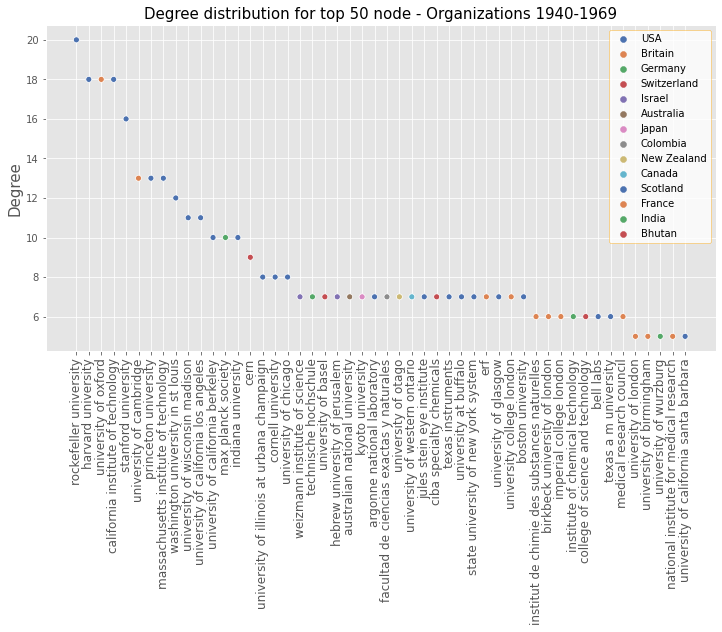

In [47]:
''' Top organization nodes with nationality as Hue '''
f = plot_top_nodes(G=G_bottom_pro,
               hue_name = '',
               hue_dict = nat_dict,
               title = f"Organizations {_period}")
# Place legend
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')
# Saving as pdf
f.savefig(f'Plots/{_period}/top_connected_university_bipart.png', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

# 1970-1999

In [48]:
_df = third_period
_period = "1970-1999"
_con_per = "1970_99"

In [49]:
import networkx as nx
from networkx.algorithms import bipartite
import netwulf as nw
plt.style.use('ggplot')

''' Create network '''
G_bi = nx.Graph()
G_bi.add_nodes_from(_df["laureate_name"], bipartite = 0)
G_bi.add_nodes_from(_df["affiliation"], bipartite = 1)
edge_list = list(_df[["laureate_name", "affiliation"]].to_records(index=False))
G_bi.add_edges_from(edge_list)

node_attr = {n:d["bipartite"] for n, d in G_bi.nodes(data=True)}
nx.set_node_attributes(G_bi, node_attr, name = 'group')

In [50]:
''' Run if config needs chaning '''
# network, config = nw.visualize(G_bi, plot_in_cell_below=False) # Run netwulf

' Run if config needs chaning '

In [51]:
''' If new configs should be saved'''
# with open(f'nx_configs/bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' If new configs should be saved'

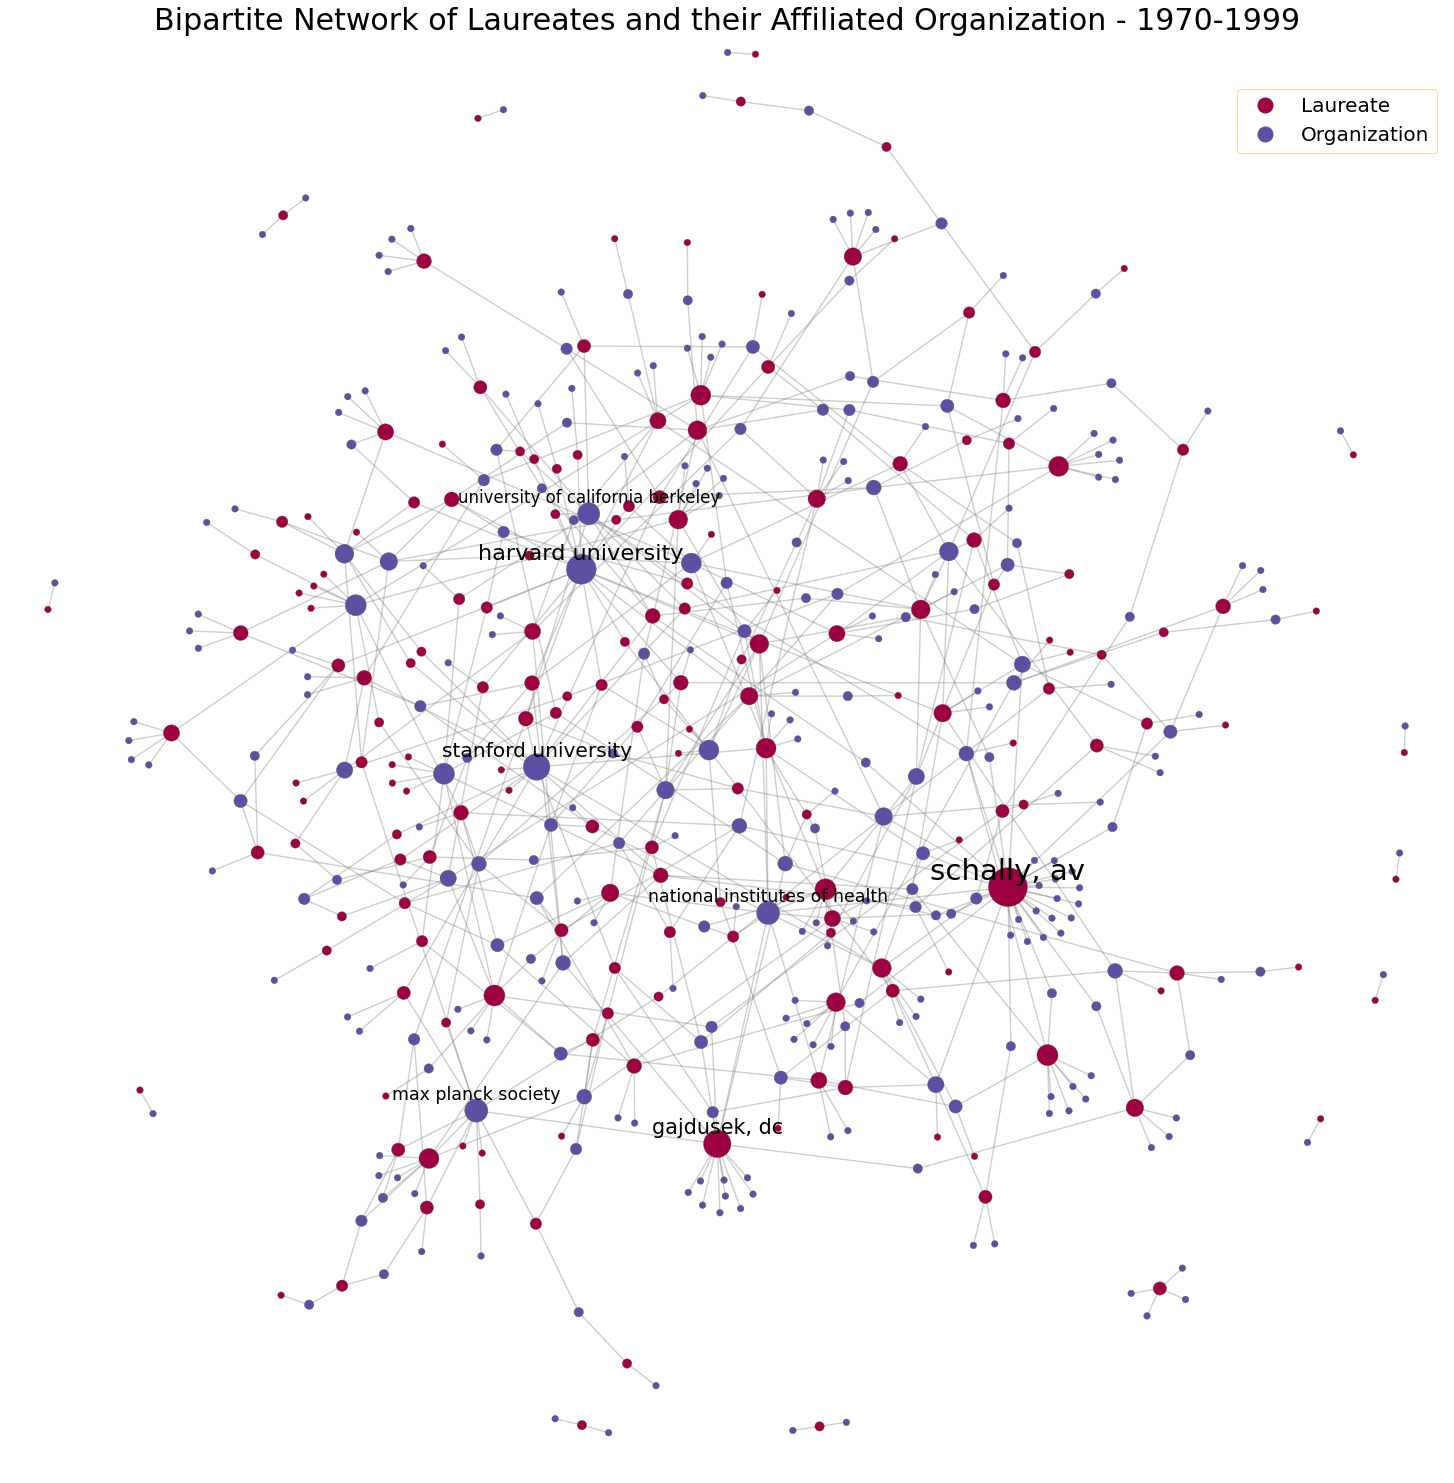

In [53]:
with open(f'nx_configs/bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bi, plot_in_cell_below=False, config = config)

network = redefine_attr(network, node_attr) # colormap it

# Drawing a big figure
plt.rcParams["figure.figsize"] = (20,20)

# Drawing the network
fig, ax = nw.draw_netwulf(network)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>8: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*2)
    else:
        pass



''' attribute/hue dicts '''
laureate_dict = dict.fromkeys(_df["laureate_name"], "Laureate")
university_dict = dict.fromkeys(_df["affiliation"], "Organization")
laureate_dict.update(university_dict)


val_map = {laureate_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 15)

# Place legend
legend = plt.legend(bbox_to_anchor = (1,0.97), fontsize = 20)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

ax.set_title(f'Bipartite Network of Laureates and their Affiliated Organization - {_period}', size = 30)

# Saving as pdf
plt.savefig(f'Plots/{_period}/bipartite_laureate_uni.', dpi=300, facecolor='w', edgecolor='w',
            bbox_inches="tight")

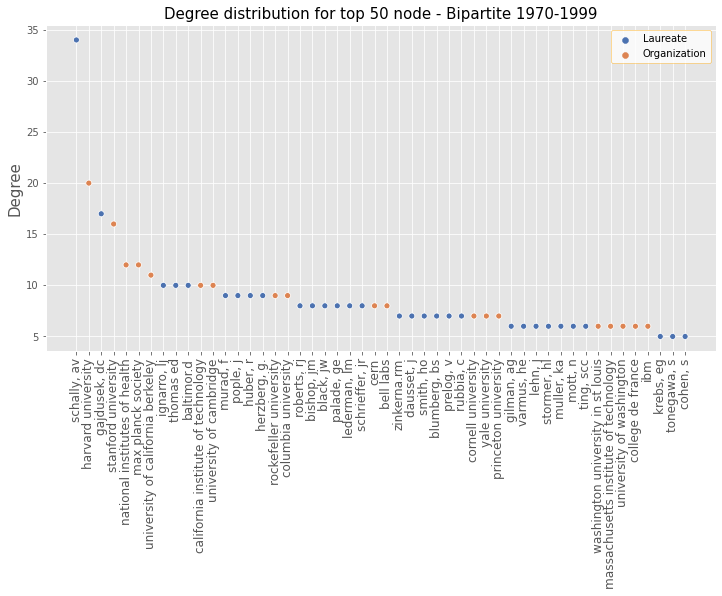

In [55]:
''' top nodes in bipartite network'''
f = plot_top_nodes(G=G_bi,
           hue_name = '',
           hue_dict = laureate_dict,
           title = f'Bipartite {_period}')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

f.savefig(f'Plots/{_period}/top_connected.', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [56]:
#### Split into projections ####
top_nodes = {n for n, d in G_bi.nodes(data=True) if d["bipartite"] == 0} # Laureates 
bottom_nodes = set(G_bi) - top_nodes

## Projections 
G_top_pro = bipartite.projection.projected_graph(G_bi, top_nodes) # laureates 
G_bottom_pro = bipartite.projection.projected_graph(G_bi, bottom_nodes) # affiliation 

''' Nationality hue for laureates '''
_df.nationality = _df.nationality.apply(lambda x: x.split(',')[0])
name_nat_dict = {name:nat for name, nat in zip(_df.laureate_name, _df.nationality)}

# Assign communty labels
nx.set_node_attributes(G_top_pro, name_nat_dict, 'group')

In [57]:
''' Run if configs needs changing '''
# #Use netwulf to visualize
# network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

' Run if configs needs changing '

In [58]:
''' Save if necesarry '''
# with open(f'nx_configs/lau_bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' Save if necesarry '

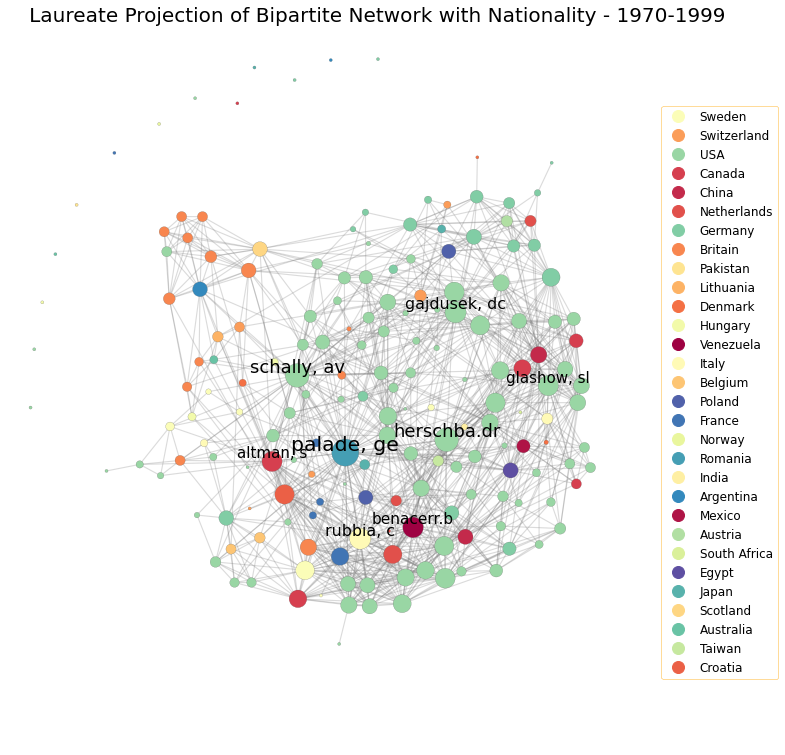

In [59]:
with open(f'nx_configs/lau_bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False, config = config)

network = redefine_attr(network, name_nat_dict) # colormap it

fig, ax = nw.draw_netwulf(network, figsize = 10)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>15: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass


    
ax.set_title(f'   Laureate Projection of Bipartite Network with Nationality - {_period}', size = 20)

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {name_nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
# Place legend
legend = plt.legend(bbox_to_anchor = (0.9,0.9), fontsize = 12)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')


# Saving as pdf
plt.savefig(f'Plots/{_period}/laureate_projection_nationality.png', dpi=300, bbox_inches='tight')

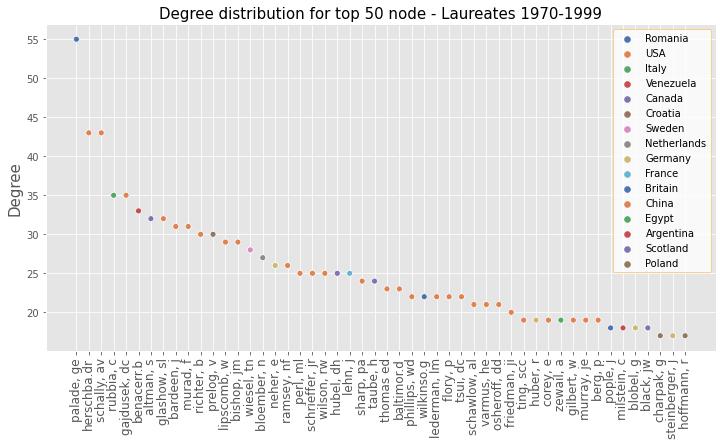

In [61]:
''' Top Laureate nodes with nationality as Hue '''
f = plot_top_nodes(G=G_top_pro,
               hue_name = '',
               hue_dict = name_nat_dict,
               title = f"Laureates {_period}")

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

f.savefig(f'Plots/{_period}/top_connected_laureate_bipart.png', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [62]:
''' Continent hue for organization ''' 
nat_dict = {name:(nat if pd.isna(nat)==False else 'USA') \
            for name, nat in zip(_df.affiliation, _df.uni_nationality)}

# Assign communty labels
nx.set_node_attributes(G_bottom_pro, nat_dict, 'group')

In [63]:
''' Run if configs needs changing'''
#Use netwulf to visualize
# network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

' Run if configs needs changing'

In [64]:
''' Save if necesarry '''
# with open(f'nx_configs/org_bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' Save if necesarry '

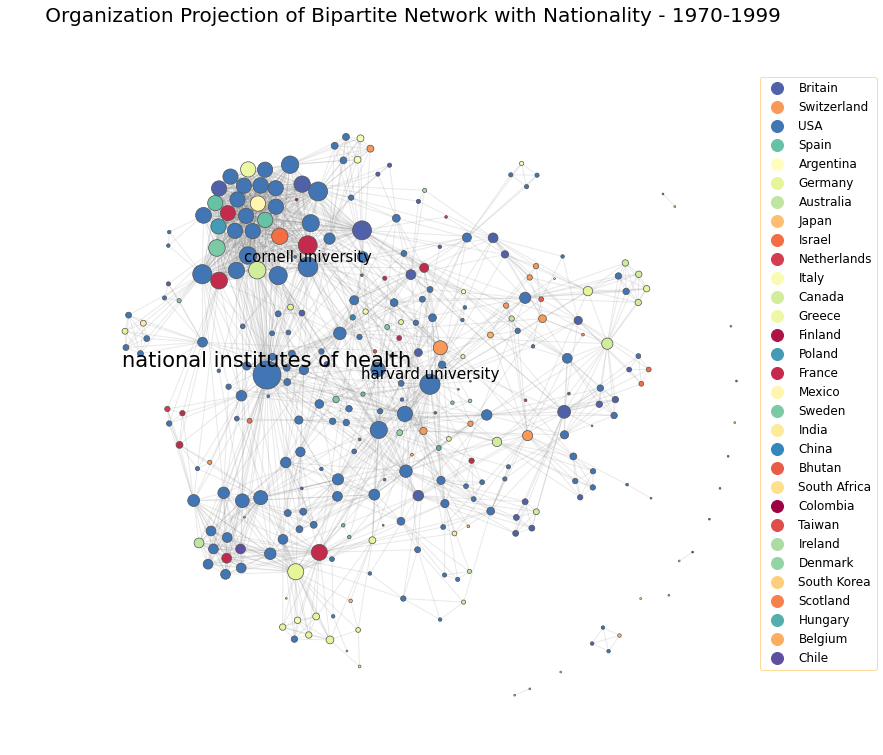

In [65]:
with open(f'nx_configs/org_bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False, config = config)

network = redefine_attr(network, nat_dict) # colormap it

fig, ax = nw.draw_netwulf(network, figsize = 10)


# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>14.5: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = network['nodes'][node_nr]['radius'],
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass


    
ax.set_title(f'      Organization Projection of Bipartite Network with Nationality - {_period}', size = 20)


val_map = {nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)

# Place legend
legend = plt.legend(bbox_to_anchor = (1,0.94), fontsize = 12)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
fig.tight_layout()
plt.savefig(f'Plots/{_period}/university_projection_continent.png', dpi=300, bbox_inches='tight')

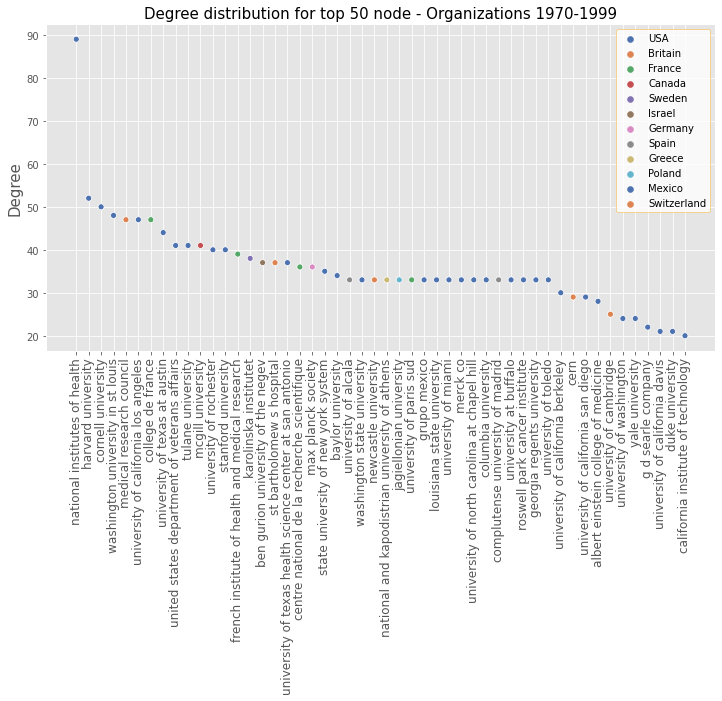

In [67]:
''' Top organization nodes with nationality as Hue '''
f = plot_top_nodes(G=G_bottom_pro,
               hue_name = '',
               hue_dict = nat_dict,
               title = f"Organizations {_period}")
# Place legend
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')
# Saving as pdf
f.savefig(f'Plots/{_period}/top_connected_university_bipart.png', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

# 2000-

In [68]:
_df = fourth_period
_period = "after 2000"
_con_per = "2000"

In [69]:
import networkx as nx
from networkx.algorithms import bipartite
import netwulf as nw
plt.style.use('ggplot')

''' Create network '''
G_bi = nx.Graph()
G_bi.add_nodes_from(_df["laureate_name"], bipartite = 0)
G_bi.add_nodes_from(_df["affiliation"], bipartite = 1)
edge_list = list(_df[["laureate_name", "affiliation"]].to_records(index=False))
G_bi.add_edges_from(edge_list)

node_attr = {n:d["bipartite"] for n, d in G_bi.nodes(data=True)}
nx.set_node_attributes(G_bi, node_attr, name = 'group')

In [70]:
''' Run if config needs chaning '''
# network, config = nw.visualize(G_bi, plot_in_cell_below=False) # Run netwulf

' Run if config needs chaning '

In [71]:
''' If new configs should be saved'''
# with open(f'nx_configs/bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' If new configs should be saved'

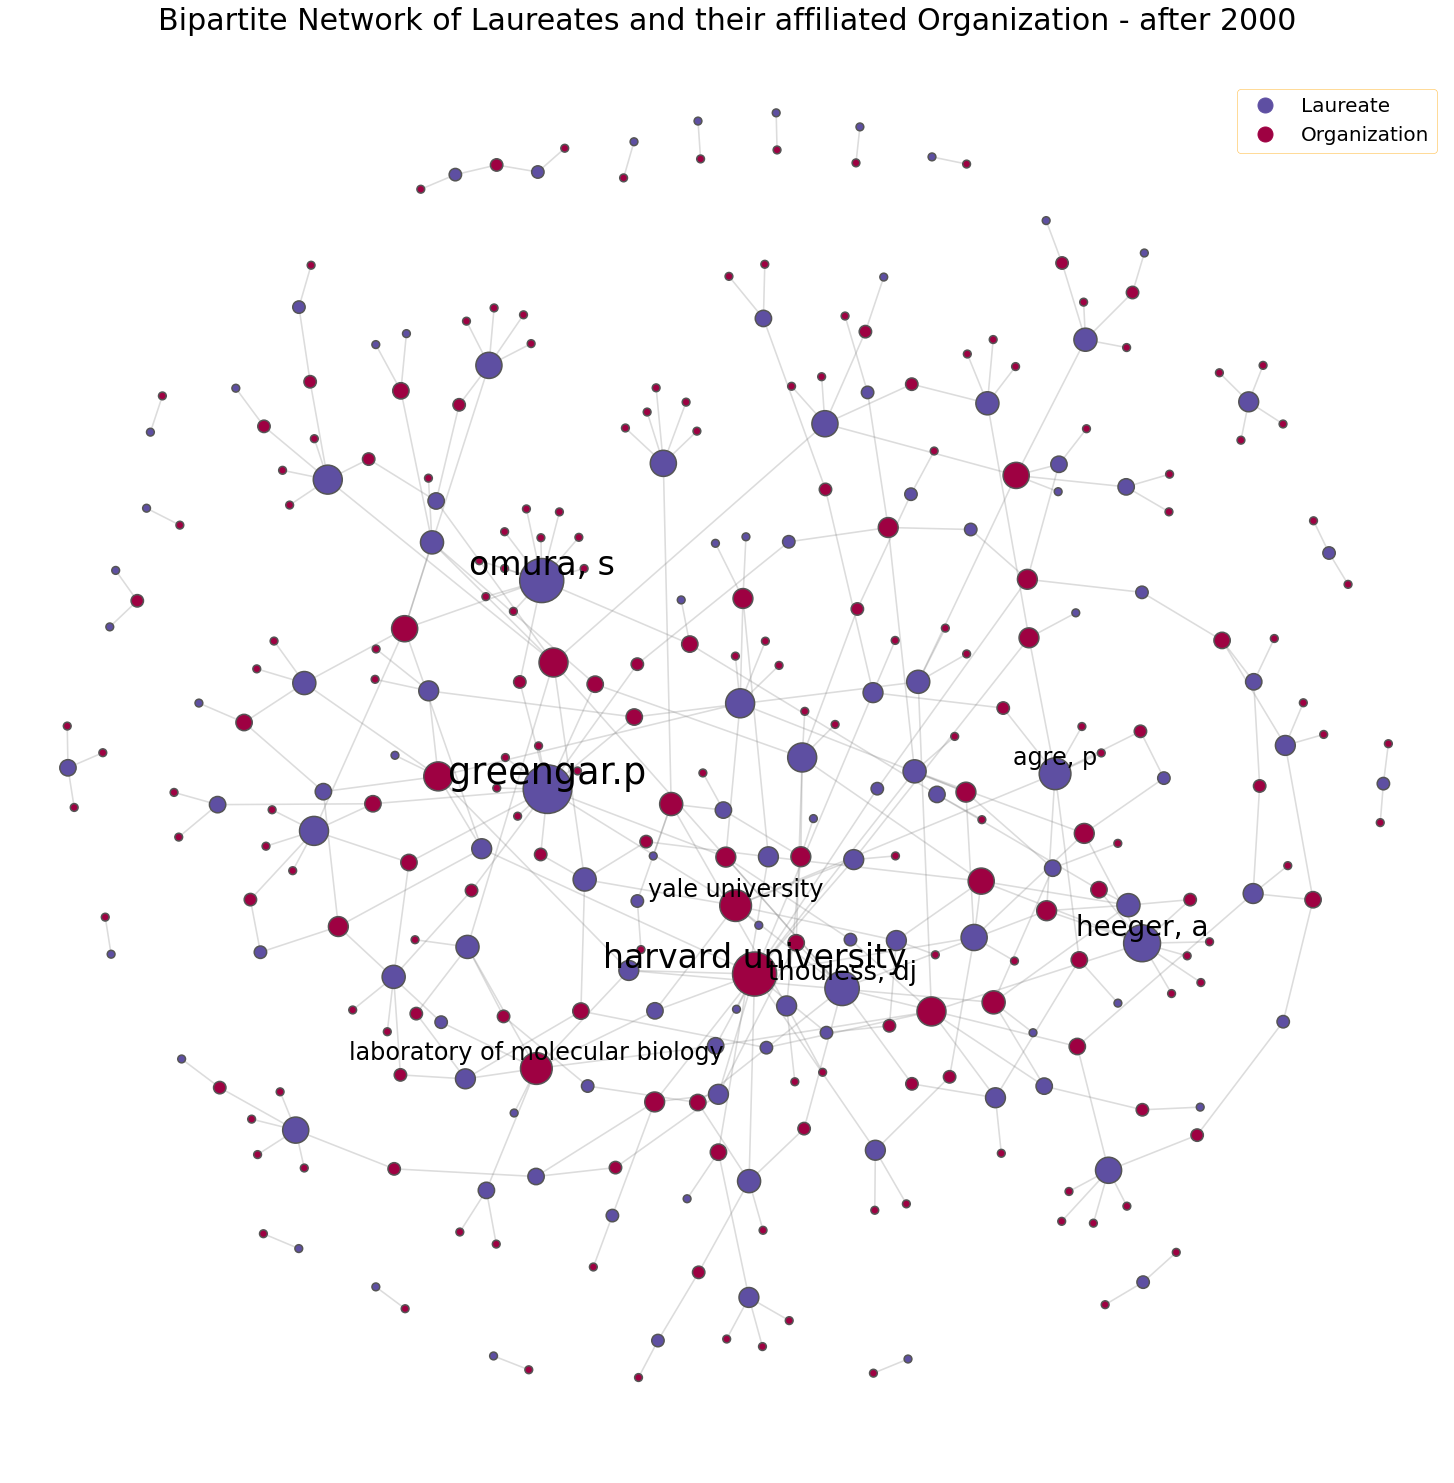

In [72]:
with open(f'nx_configs/bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bi, plot_in_cell_below=False, config = config)

network = redefine_attr(network, node_attr) # colormap it

# Drawing a big figure
plt.rcParams["figure.figsize"] = (20,20)

# Drawing the network
fig, ax = nw.draw_netwulf(network)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>11: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*2)
    else:
        pass



''' attribute/hue dicts '''
laureate_dict = dict.fromkeys(_df["laureate_name"], "Laureate")
university_dict = dict.fromkeys(_df["affiliation"], "Organization")
laureate_dict.update(university_dict)


val_map = {laureate_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 15)

# Place legend
legend = plt.legend(bbox_to_anchor = (1,0.97), fontsize = 20)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

ax.set_title(f'Bipartite Network of Laureates and their affiliated Organization - {_period}', size = 30)

# Saving as pdf
plt.savefig(f'Plots/{_period}/bipartite_laureate_uni.', dpi=300, facecolor='w', edgecolor='w',
            bbox_inches="tight")

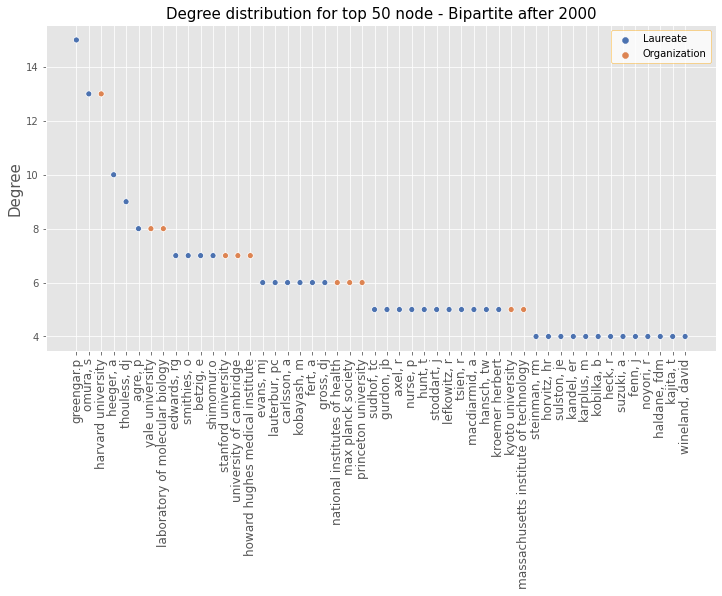

In [73]:
''' top nodes in bipartite network'''
f = plot_top_nodes(G=G_bi,
           hue_name = '',
           hue_dict = laureate_dict,
           title = f'Bipartite {_period}')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

f.savefig(f'Plots/{_period}/top_connected.', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [74]:
#### Split into projections ####
top_nodes = {n for n, d in G_bi.nodes(data=True) if d["bipartite"] == 0} # Laureates 
bottom_nodes = set(G_bi) - top_nodes

## Projections 
G_top_pro = bipartite.projection.projected_graph(G_bi, top_nodes) # laureates 
G_bottom_pro = bipartite.projection.projected_graph(G_bi, bottom_nodes) # affiliation 

''' Nationality hue for laureates '''
_df.nationality = _df.nationality.apply(lambda x: x.split(',')[0])
name_nat_dict = {name:nat for name, nat in zip(_df.laureate_name, _df.nationality)}

# Assign communty labels
nx.set_node_attributes(G_top_pro, name_nat_dict, 'group')

In [75]:
''' Run if configs needs changing '''
# #Use netwulf to visualize
# network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

' Run if configs needs changing '

In [76]:
''' Save if necesarry '''
# with open(f'nx_configs/lau_bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' Save if necesarry '

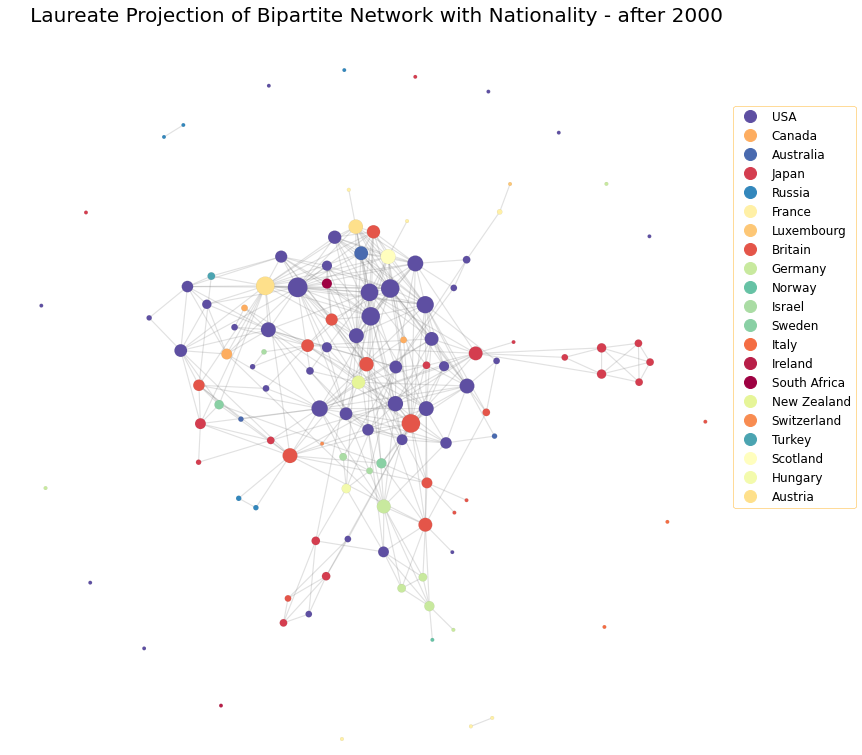

In [107]:
with open(f'nx_configs/lau_bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False, config = config)

network = redefine_attr(network, name_nat_dict) # colormap it

fig, ax = nw.draw_netwulf(network, figsize = 10)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>15: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass


    
ax.set_title(f'   Laureate Projection of Bipartite Network with Nationality - {_period}', size = 20)


val_map = {name_nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
# Place legend
legend = plt.legend(bbox_to_anchor = (1,0.9), fontsize = 12)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')


# Saving as pdf
plt.savefig(f'Plots/{_period}/laureate_projection_nationality.png', dpi=300, bbox_inches='tight')

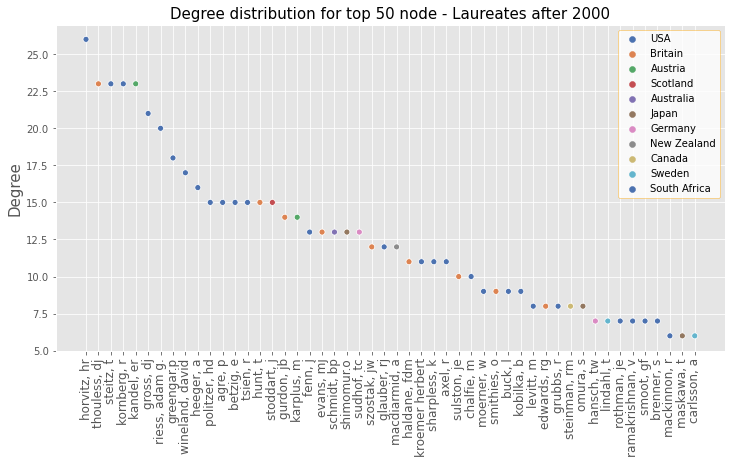

In [108]:
''' Top Laureate nodes with nationality as Hue '''
f = plot_top_nodes(G=G_top_pro,
               hue_name = '',
               hue_dict = name_nat_dict,
               title = f"Laureates {_period}")

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

f.savefig(f'Plots/{_period}/top_connected_laureate_bipart.png', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [109]:
''' Continent hue for organization ''' 
nat_dict = {name:(nat if pd.isna(nat)==False else 'USA') \
            for name, nat in zip(_df.affiliation, _df.uni_nationality)}

# Assign communty labels
nx.set_node_attributes(G_bottom_pro, nat_dict, 'group')

In [110]:
''' Run if configs needs changing'''
#Use netwulf to visualize
# network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

' Run if configs needs changing'

In [111]:
''' Save if necesarry '''
# with open(f'nx_configs/org_bipartite_{_con_per}.json', 'w', encoding = "utf-8") as f:
#     json.dump(config, f)

' Save if necesarry '

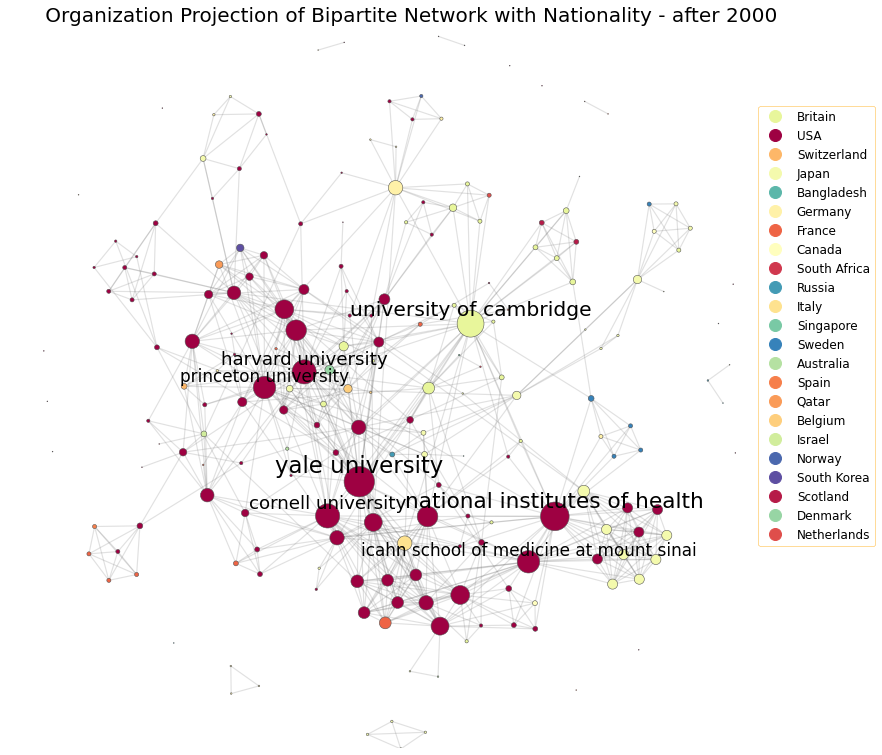

In [112]:
with open(f'nx_configs/org_bipartite_{_con_per}.json', 'r', encoding = "utf-8") as f:
    config = json.load(f)
    
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False, config = config)

network = redefine_attr(network, nat_dict) # colormap it

fig, ax = nw.draw_netwulf(network, figsize = 10)


# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>16: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = network['nodes'][node_nr]['radius'],
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius'])
    else:
        pass


    
ax.set_title(f'      Organization Projection of Bipartite Network with Nationality - {_period}', size = 20)


val_map = {nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)

# Place legend
legend = plt.legend(bbox_to_anchor = (1,0.9), fontsize = 12)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')

# Saving as pdf
fig.tight_layout()
plt.savefig(f'Plots/{_period}/university_projection_continent.png', dpi=300, bbox_inches='tight')

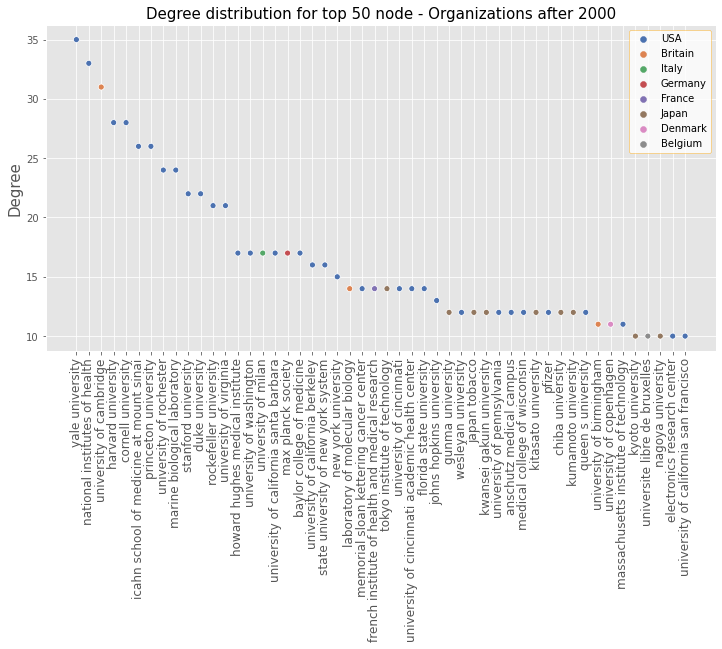

In [114]:
''' Top organization nodes with nationality as Hue '''
f = plot_top_nodes(G=G_bottom_pro,
               hue_name = '',
               hue_dict = nat_dict,
               title = f"Organizations {_period}")
# Place legend
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('orange')
# Saving as pdf
f.savefig(f'Plots/{_period}/top_connected_university_bipart.png', dpi=300, facecolor='w', edgecolor='w',
         bbox_inches="tight")